In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

2024-11-26 12:22:14.250206: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 12:22:14.289970: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 12:22:14.290546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 12:22:15.050014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pandas as pd
import numpy as np

TS = 48 # Time steps

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df.head()

Customer             1                    3                 4           \
categories            GG      GC      CL   GG      GC   CL   GG     GC   
2012-07-01 00:30:00  0.0  1710.0  2500.0  0.0  1930.0  0.0  0.0  168.0   
2012-07-01 01:00:00  0.0  1572.0  2500.0  0.0  1854.0  0.0  0.0  168.0   
2012-07-01 01:30:00  0.0  1208.0  2500.0  0.0  2718.0  0.0  0.0  164.0   
2012-07-01 02:00:00  0.0  1088.0  2526.0  0.0   120.0  0.0  0.0  168.0   
2012-07-01 02:30:00  0.0  1194.0   262.0  0.0   118.0  0.0  0.0  172.0   

Customer                     5    ...  297                 298         299  \
categories               CL   GG  ...   GG     GC      CL   GG     GC   GG   
2012-07-01 00:30:00     0.0  0.0  ...  0.0  282.0     0.0  0.0  314.0  0.0   
2012-07-01 01:00:00     0.0  0.0  ...  0.0  514.0     0.0  0.0  254.0  0.0   
2012-07-01 01:30:00  3860.0  0.0  ...  0.0  394.0     0.0  0.0  244.0  0.0   
2012-07-01 02:00:00  3956.0  0.0  ...  0.0  546.0  2660.0  0.0  240.0  0.0   
2012-07-01 02:30:00  1568.0  0.0  ...  0.0  412.0     0.0  0.0  212.0  0.0   

Customer                     300                 
categories               GC   GG     GC      CL  
2012-07-01 00:30:00  1082.0  0.0  438.0  5346.0  
2012-07-01 01:00:00   200.0  0.0  198.0  2492.0  
2012-07-01 01:30:00   180.0  0.0  268.0     0.0  
2012-07-01 02:00:00   188.0  0.0  200.0     0.0  
2012-07-01 02:30:00    92.0  0.0  246.0     0.0  

[5 rows x 725 columns]

In [3]:
customers = sorted(df.columns.levels[0])
max_values = []
for c in customers:
    max_values.append(df[c]['GG'].max())

normalize = max(max_values)
print(normalize)



8662.0


In [4]:
def gen_data(X, y, num_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - num_steps):        
        Xs.append(np.reshape(X[i:(i + num_steps)], (num_steps, 1)))
        ys.append(y[i + num_steps])
    return np.array(Xs), np.reshape(np.array(ys), (len(ys)))
    
customers = sorted(df.columns.levels[0])
x_list = []
y_list = []
for c in customers[:12]:
    tmp = df[c]['GG'].to_numpy()/normalize
    tmp_x, tmp_y = gen_data(tmp, tmp, TS)        
    x_list.append(tmp_x)
    y_list.append(tmp_y)
x_data = np.array(x_list)
y_data = np.array(y_list)
print(x_data.shape, y_data.shape)


(12, 17472, 48, 1) (12, 17472)


In [5]:
NT = 10
x_train, y_train = x_data[:NT], y_data[:NT]
print(x_train.shape, y_train.shape)
x_test, y_test = x_data[NT:], y_data[NT:]
print(x_test.shape, y_test.shape)

(10, 17472, 48, 1) (10, 17472)
(2, 17472, 48, 1) (2, 17472)


In [6]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
# x_train = np.expand_dims(x_train, -1)  # 채널 차원 추가
# x_test = np.expand_dims(x_test, -1)  # 채널 차원 추가
# y_train = tf.keras.utils.to_categorical(y_train, 10)
# y_test = tf.keras.utils.to_categorical(y_test, 10)
x_train.shape

(10, 17472, 48, 1)

In [7]:
# 연합학습을 위한 데이터 분할
num_clients = 5
client_data_size = len(x_train) // num_clients
client_data = [(x_train[i * client_data_size: (i + 1) * client_data_size],
                y_train[i * client_data_size: (i + 1) * client_data_size])
               for i in range(num_clients)]
# len(client_data)
client_data[0][1].shape

(2, 17472)

In [8]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

def create_model():
    model = Sequential([
        LSTM(256, activation='relu', input_shape=(x_train.shape[2], x_train.shape[3]), return_sequences=True),
        LSTM(16),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')
    return model

In [9]:
# 모델 생성
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 16)                17472     
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 281681 (1.07 MB)
Trainable params: 281681 (1.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# 클라이언트 모델 초기화
def initialize_client_models(num_clients, global_weights=None):
    client_models = []
    for _ in range(num_clients):
        model = create_model()
        if global_weights is not None:
            model.set_weights(global_weights)  # 모든 클라이언트 모델에 동일한 글로벌 가중치 설정
        client_models.append(model)
    return client_models

# FedAvg로 글로벌 모델 업데이트 함수
def federated_averaging(client_models, client_data):
    global_model = create_model()
    
    # 클라이언트 데이터 샘플 수를 기준으로 가중치 계산
    num_samples = [data[0].shape[0] for data in client_data]
    total_samples = sum(num_samples)
    client_weights = [samples / total_samples for samples in num_samples]
    
    # 각 클라이언트의 가중치를 평균화
    model_weights = [model.get_weights() for model in client_models]
    average_weights = []
    for weights_list in zip(*model_weights):
        average_weights.append(np.average(weights_list, axis=0, weights=client_weights))
    
    global_model.set_weights(average_weights)
    return global_model

# 각 클라이언트 모델 학습 함수
def train_client_model(client_data, model, epochs=1, batch_size=32):
    print(client_data[0].shape)
    # history = model.fit(client_data[0], client_data[1], epochs=epochs, batch_size=batch_size, verbose=1)
    for x, y in zip(client_data[0], client_data[1]):
        history = model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return history

def evaluate_global(model, x_test, y_test):
    total_test_loss = 0.0
    total_test_acc = 0.0
    for x_ev, y_ev in zip(x_test, y_test):
        print(x_ev.shape, y_ev.shape)
        test_loss, test_acc = model.evaluate(x_ev, y_ev, verbose=0)
        total_test_loss += test_loss
        total_test_acc += test_acc

    return total_test_loss/(len(x_test)), total_test_acc/(len(y_test))
        
# 연합 학습 반복 함수
def federated_learning(num_rounds, num_clients, client_data):
    # 초기 글로벌 모델 설정
    global_model = create_model()
    global_model_accuracies = []
    
    for round in range(num_rounds):
        print(f"Round {round + 1}/{num_rounds}")
        
        # 클라이언트 모델 초기화
        client_models = initialize_client_models(num_clients, global_weights=global_model.get_weights())
        
        # 클라이언트 모델 학습
        for i in range(num_clients):
            print(f"Training client model {i + 1}...")
            train_client_model(client_data[i], client_models[i])
        
        # Create Global model as FedAvg
        global_model = federated_averaging(client_models, client_data)
        
        # Evaluate Global model
        # test_loss, test_acc = global_model.evaluate(x_test[0], y_test[0], verbose=0)
        test_loss, test_acc = evaluate_global(global_model, x_test, y_test)
        global_model_accuracies.append(test_acc * 100)
        print(f'Global model test accuracy: {test_acc * 100:.2f}%')
        
        # Show learning status
        # client_accuracies = [model.evaluate(x_test, y_test, verbose=0)[1] for model in client_models]
        client_accuracies = [evaluate_global(model, x_test, y_test)[1] for model in client_models]

        plt.figure(figsize=(10, 6))
        plt.plot(range(num_clients), client_accuracies, 'bo-', label='Client Models')
        plt.axhline(y=test_acc, color='r', linestyle='-', label='Global Model')
        plt.xlabel('Client')
        plt.ylabel('Accuracy')
        plt.title(f'Client Models vs Global Model Accuracy (Round {round + 1})')
        plt.legend()
        plt.show()

        # Show prediction with a random sample 
        num_samples = x_test.shape[0]
        test_index = np.random.randint(num_samples)

        plt.figure(figsize=(12, 6))

        for i in range(num_clients):
            plt.subplot(2, num_clients, i + 1)
            y_pred = client_models[i].predict(x_test[test_index])
            plt.plot(y_test[test_index][:48*5], marker='.', label='True')
            plt.plot(y_pred[:48*5], 'r', label='Prediction')
            plt.title(f"Client {i+1}")
            plt.axis('off')

        plt.subplot(2, num_clients, num_clients + 1)
        y_pred = global_model.predict(x_test[test_index])
        plt.plot(y_test[test_index][:48*5], marker='.', label='True')
        plt.plot(y_pred[:48*5], 'r', label='Prediction')
        plt.title(f"Global Model")
        plt.axis('off')

        plt.show()

    return global_model, global_model_accuracies

(2, 17472, 48, 1) (2, 17472)
Round 1/2
Training client model 1...
(2, 17472, 48, 1)
546/546 [==============================] - 24s 44ms/step - loss: 8.5815e-05 - accuracy: 0.5298
Training client model 2...
(2, 17472, 48, 1)
546/546 [==============================] - 25s 47ms/step - loss: 4.4177e-05 - accuracy: 0.5468
Training client model 3...
(2, 17472, 48, 1)
546/546 [==============================] - 25s 47ms/step - loss: 2.9051e-04 - accuracy: 0.5394
Training client model 4...
(2, 17472, 48, 1)
546/546 [==============================] - 26s 48ms/step - loss: 5.5715e-05 - accuracy: 0.5548
Training client model 5...
(2, 17472, 48, 1)
546/546 [==============================] - 26s 48ms/step - loss: 1.5246e-04 - accuracy: 0.5241
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
Global model test accuracy: 53.37%
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48

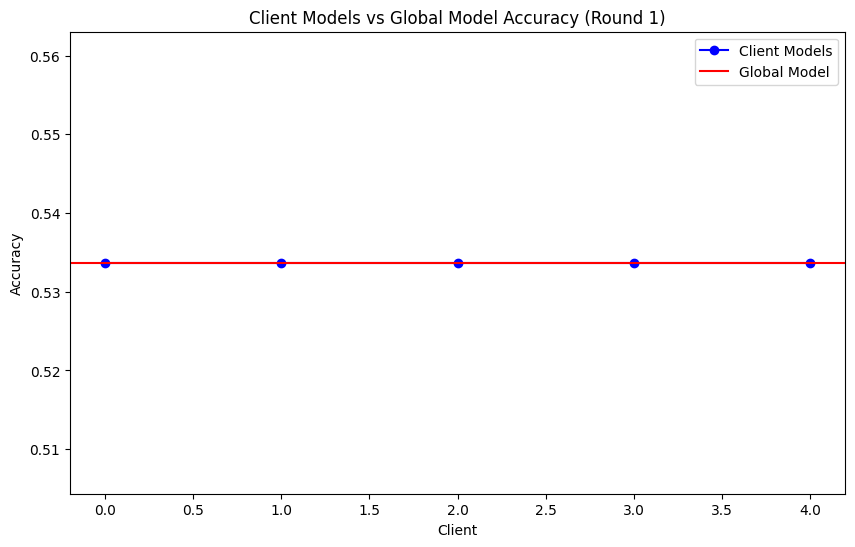

546/546 [==============================] - 10s 17ms/step


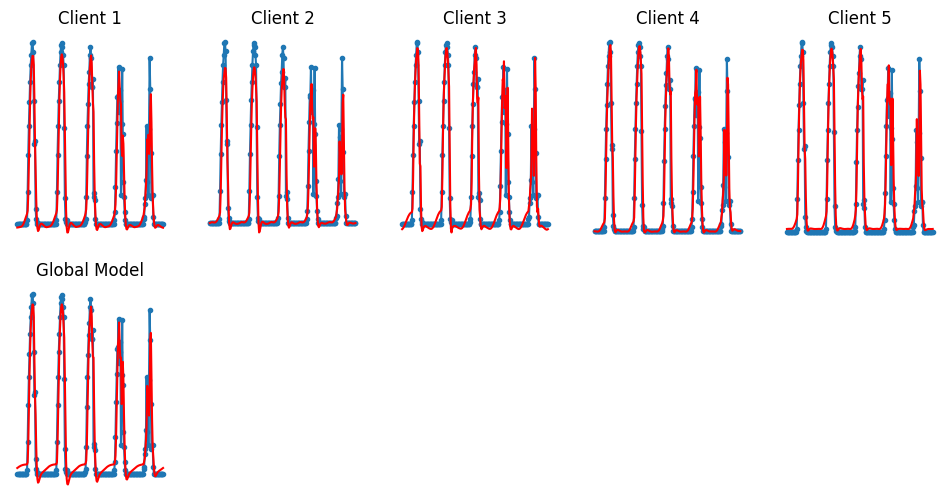

Round 2/2
Training client model 1...
(2, 17472, 48, 1)
546/546 [==============================] - 28s 52ms/step - loss: 6.2062e-05 - accuracy: 0.5298
Training client model 2...
(2, 17472, 48, 1)
546/546 [==============================] - 26s 48ms/step - loss: 3.7670e-05 - accuracy: 0.5468
Training client model 3...
(2, 17472, 48, 1)
546/546 [==============================] - 26s 48ms/step - loss: 2.6606e-04 - accuracy: 0.5394
Training client model 4...
(2, 17472, 48, 1)
546/546 [==============================] - 27s 50ms/step - loss: 4.7548e-05 - accuracy: 0.5548
Training client model 5...
(2, 17472, 48, 1)
546/546 [==============================] - 27s 50ms/step - loss: 1.3262e-04 - accuracy: 0.5241
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
Global model test accuracy: 53.37%
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
(17472, 48, 1) 

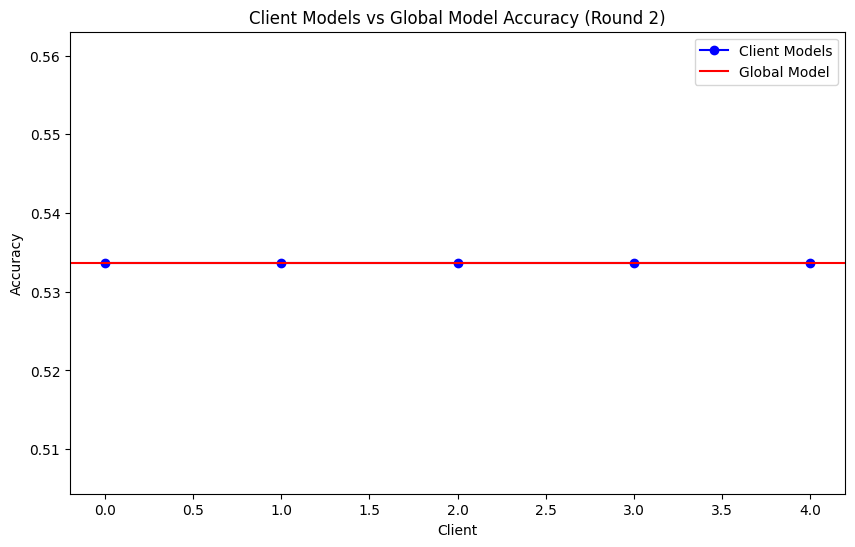

546/546 [==============================] - 10s 17ms/step


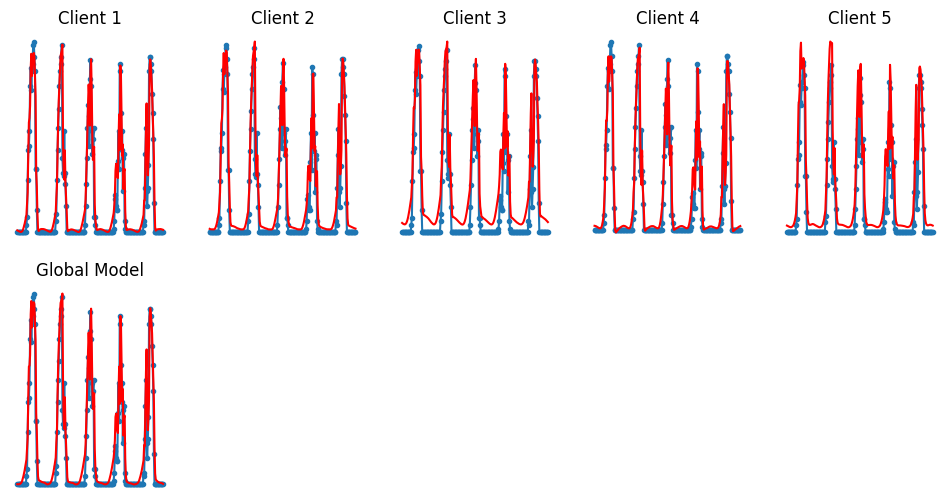

In [11]:
print(x_test.shape, y_test.shape)

# 연합 학습 수행
num_rounds = 2
global_model, global_model_accuracies = federated_learning(num_rounds, num_clients, client_data)

(17472, 48, 1) (17472,)
(17472, 48, 1) (17472,)
Final global model test accuracy: 53.37%


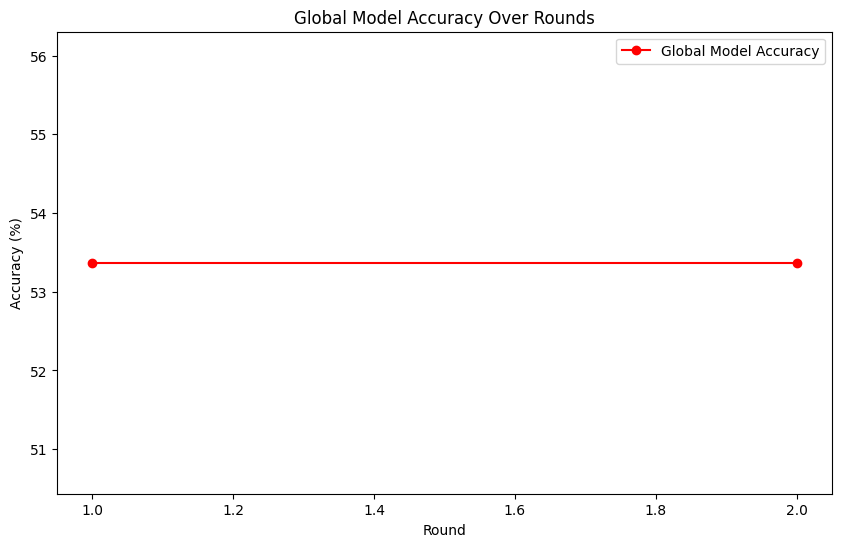

In [12]:
# 최종 글로벌 모델 평가
# test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)
test_loss, test_acc = evaluate_global(global_model, x_test, y_test)
print(f'Final global model test accuracy: {test_acc * 100:.2f}%')

# 라운드에 따른 글로벌 모델 정확도 변화 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_rounds + 1), global_model_accuracies, 'r-o', label='Global Model Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Global Model Accuracy Over Rounds')
plt.legend()
plt.show()

546/546 [==============================] - 9s 16ms/step


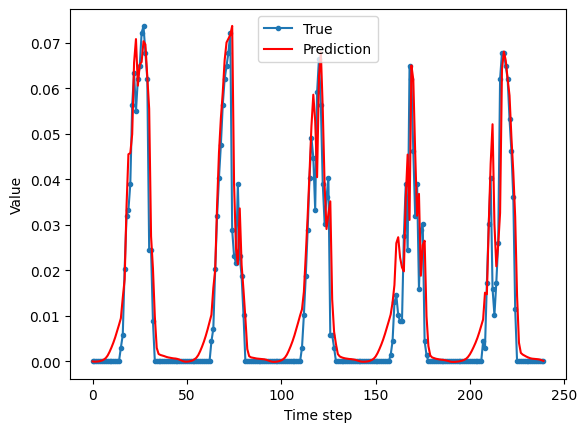

In [13]:
y_pred = global_model.predict(x_test[0])
plt.plot(y_test[0][:48*5], marker='.', label='True')
plt.plot(y_pred[:48*5], 'r', label='Prediction')
plt.ylabel('Value')
plt.xlabel('Time step')
plt.legend()
plt.show()
